In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './datasets/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

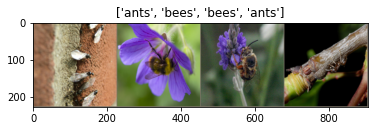

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model: nn.Module, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5772 Acc: 0.7131
val Loss: 0.2269 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4833 Acc: 0.8197
val Loss: 0.2762 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.6735 Acc: 0.7090
val Loss: 0.2564 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.5055 Acc: 0.7787
val Loss: 0.6293 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.6083 Acc: 0.8320
val Loss: 1.5461 Acc: 0.6928

Epoch 5/24
----------
train Loss: 0.7107 Acc: 0.7705
val Loss: 0.3535 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.6191 Acc: 0.7582
val Loss: 0.2225 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3135 Acc: 0.8689
val Loss: 0.2050 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3117 Acc: 0.8648
val Loss: 0.2001 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3485 Acc: 0.8279
val Loss: 0.2135 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2810 Acc: 0.8689
val Loss: 0.2171 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3179 Acc: 0.8811
val Loss: 0.2397 Acc: 0.9085

Ep

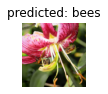

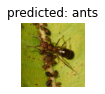

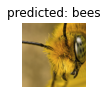

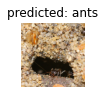

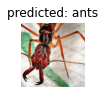

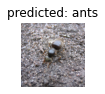

In [20]:
visualize_model(model_ft)

In [6]:
def evaluate_model(model):
    model.eval()
    total_count = 0
    correct_count = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if preds[j] == labels[j]:
                    correct_count += 1
                total_count += 1
    return correct_count / total_count

In [27]:
print(evaluate_model(model_ft))

torch.save(model_ft, './models/resnetBeeAnt')

0.9281045751633987


In [7]:
model_name = "cp"
model_compressed = torch.load('./models/compressedBeeAnts/' + model_name + '_model_1')

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_compressed.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_compressed = model_compressed.to(device)

model_compressed = train_model(model_compressed, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

print(evaluate_model(model_compressed))

torch.save(model_compressed, './models/compressedBeeAnts/retrained_' + model_name + '_model_1')

Epoch 0/24
----------
train Loss: 0.7875 Acc: 0.5861
val Loss: 0.6093 Acc: 0.7190

Epoch 1/24
----------
train Loss: 0.7518 Acc: 0.6475
val Loss: 0.9759 Acc: 0.7059

Epoch 2/24
----------
train Loss: 0.7225 Acc: 0.7172
val Loss: 0.7874 Acc: 0.6732

Epoch 3/24
----------
train Loss: 0.6535 Acc: 0.6680
val Loss: 0.5230 Acc: 0.7451

Epoch 4/24
----------
train Loss: 0.5292 Acc: 0.7254
val Loss: 0.6550 Acc: 0.7582

Epoch 5/24
----------
train Loss: 0.6381 Acc: 0.6844
val Loss: 0.8186 Acc: 0.6601

Epoch 6/24
----------
train Loss: 0.6003 Acc: 0.7295
val Loss: 0.4426 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.4677 Acc: 0.7869
val Loss: 0.4351 Acc: 0.8301

Epoch 8/24
----------
train Loss: 0.4281 Acc: 0.8115
val Loss: 0.4686 Acc: 0.8235

Epoch 9/24
----------
train Loss: 0.4289 Acc: 0.8156
val Loss: 0.4630 Acc: 0.8105

Epoch 10/24
----------
train Loss: 0.4487 Acc: 0.7705
val Loss: 0.4572 Acc: 0.8235

Epoch 11/24
----------
train Loss: 0.4266 Acc: 0.7992
val Loss: 0.5344 Acc: 0.8039

Ep

In [31]:
import gc
del model_compressed
del model_ft

gc.collect()
torch.cuda.empty_cache()

In [9]:
model_compressed = torch.load('./models/compressedBeeAnts/' + model_name + '_model_1')
print(evaluate_model(model_compressed))

0.9019607843137255
